# Ordinal Cluster Arrangement
C. Heiser, 2019

---
__The purpose of this notebook is to prototype methods for determining ordinal arrangement of substructures within single-cell data.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse retina scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

---
First, read in retina and colon datasets with all genes present

In [2]:
# read in Macosko retina data
retina = sc.read_text('../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [7]:
retina.obs['cluster_fcc'] = np.genfromtxt('outputs/embeddings/retina_clu.csv')

In [8]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'cluster_fcc', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [9]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [10]:
colon.obs['cluster_fcc'] = np.genfromtxt('outputs/embeddings/colon_clu.csv')

In [11]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'cluster_fcc', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
## PCA

In [12]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=2)
retina.obsm['pca2'] = retina.obsm['X_pca'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=10)
retina.obsm['pca10'] = retina.obsm['X_pca'].copy()

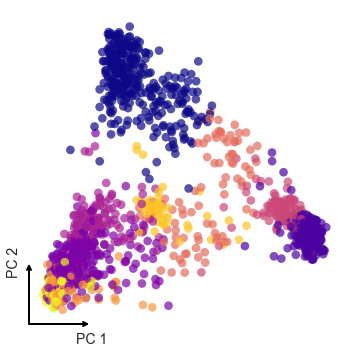

In [13]:
DR_plot(dim_name='PC').plot_IDs(retina, use_rep='X_pca', obs_col='cluster_fcc')

Now perform same analysis on colon dataset

In [14]:
colon.X = colon.layers['arcsinh_norm'].copy()
sc.tl.pca(colon, use_highly_variable=False, n_comps=2)
colon.obsm['pca2'] = colon.obsm['X_pca'].copy()
sc.tl.pca(colon, use_highly_variable=False, n_comps=10)
colon.obsm['pca10'] = colon.obsm['X_pca'].copy()

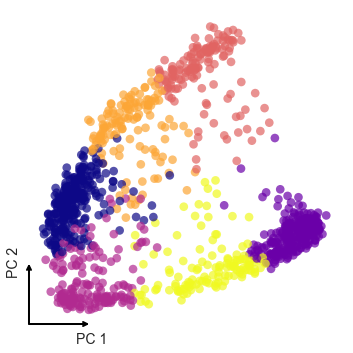

In [15]:
DR_plot(dim_name='PC').plot_IDs(colon, use_rep='X_pca', obs_col='cluster_fcc')

---
## Read in other dimension-reduced spaces for each dataset

In [16]:
retina.obsm['tsne'] = np.genfromtxt('outputs/embeddings/retina_tSNE.csv', delimiter=',')
retina.obsm['umap'] = np.genfromtxt('outputs/embeddings/retina_UMAP.csv', delimiter=',')
retina.obsm['fitsne'] = np.genfromtxt('outputs/embeddings/retina_FItSNE.csv', delimiter=',')
retina.obsm['dca'] = np.genfromtxt('outputs/embeddings/retina_DCA.csv', delimiter=',')
retina.obsm['glmpca'] = np.genfromtxt('outputs/embeddings/retina_GLM-PCA.csv', delimiter=',', skip_header=1)
retina.obsm['scvi'] = np.genfromtxt('outputs/embeddings/retina_scVI_tSNE.csv', delimiter=',')
retina.obsm['simlr'] = np.genfromtxt('outputs/embeddings/retina_SIMLR_ydata.csv', delimiter=',', skip_header=1)
retina.obsm['zifa'] = np.genfromtxt('outputs/embeddings/retina_ZIFA.csv', delimiter=',')
retina.obsm['zinbwave'] = np.genfromtxt('outputs/embeddings/retina_ZINB-WAVE.csv', delimiter=',', skip_header=1)
retina.obsm['scvis'] = np.genfromtxt('scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', 
                                     delimiter='\t', skip_header=1, usecols=(1,2))

In [17]:
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'cluster_fcc', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'pca2', 'pca10', 'tsne', 'umap', 'fitsne', 'dca', 'glmpca', 'scvi', 'simlr', 'zifa', 'zinbwave', 'scvis'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm'

In [18]:
colon.obsm['tsne'] = np.genfromtxt('outputs/embeddings/colon_tSNE.csv', delimiter=',')
colon.obsm['umap'] = np.genfromtxt('outputs/embeddings/colon_UMAP.csv', delimiter=',')
colon.obsm['fitsne'] = np.genfromtxt('outputs/embeddings/colon_FItSNE.csv', delimiter=',')
colon.obsm['dca'] = np.genfromtxt('outputs/embeddings/colon_DCA.csv', delimiter=',')
colon.obsm['glmpca'] = np.genfromtxt('outputs/embeddings/colon_GLM-PCA.csv', delimiter=',', skip_header=1)
colon.obsm['scvi'] = np.genfromtxt('outputs/embeddings/colon_scVI_tSNE.csv', delimiter=',')
colon.obsm['simlr'] = np.genfromtxt('outputs/embeddings/colon_SIMLR_ydata.csv', delimiter=',', skip_header=1)
colon.obsm['zifa'] = np.genfromtxt('outputs/embeddings/colon_ZIFA.csv', delimiter=',')
colon.obsm['zinbwave'] = np.genfromtxt('outputs/embeddings/colon_ZINB-WAVE.csv', delimiter=',', skip_header=1)
colon.obsm['scvis'] = np.genfromtxt('scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', 
                                     delimiter='\t', skip_header=1, usecols=(1,2))

In [19]:
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'cluster_fcc', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'pca2', 'pca10', 'tsne', 'umap', 'fitsne', 'dca', 'glmpca', 'scvi', 'simlr', 'zifa', 'zinbwave', 'scvis'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm'

---
### Compare MST topology

In [20]:
find_centroids(retina, use_rep='X', obs_col='cluster_fcc')
find_centroids(retina, use_rep='pca2', obs_col='cluster_fcc')
find_centroids(retina, use_rep='tsne', obs_col='cluster_fcc')
find_centroids(retina, use_rep='umap', obs_col='cluster_fcc')
find_centroids(retina, use_rep='dca', obs_col='cluster_fcc')
find_centroids(retina, use_rep='fitsne', obs_col='cluster_fcc')
find_centroids(retina, use_rep='scvi', obs_col='cluster_fcc')
find_centroids(retina, use_rep='zifa', obs_col='cluster_fcc')
find_centroids(retina, use_rep='glmpca', obs_col='cluster_fcc')
find_centroids(retina, use_rep='simlr', obs_col='cluster_fcc')
find_centroids(retina, use_rep='zinbwave', obs_col='cluster_fcc')
find_centroids(retina, use_rep='pca10', obs_col='cluster_fcc')
find_centroids(retina, use_rep='scvis', obs_col='cluster_fcc')

In [22]:
permutations = {'retina':{}, 'colon':{}} # initialize dictionary for final edge permutation stats

2 permuted edges from native space.


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


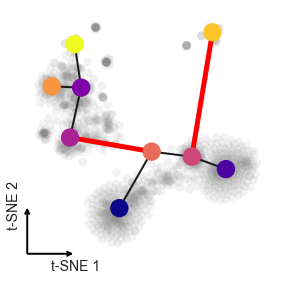

In [23]:
tsne_set = set(retina.uns['tsne_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(tsne_set)))
permutations['retina']['t-SNE'] = len(tsne_set)
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='tsne', highlight_edges=tsne_set, save_to='outputs/plots/ordinal_arrangement/retina_tSNE_MST.png')

1 permuted edges from native space.


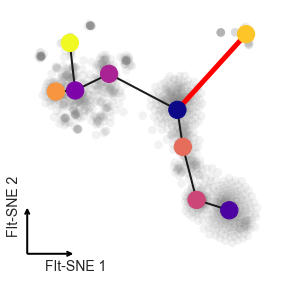

In [24]:
fitsne_set = set(retina.uns['fitsne_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(fitsne_set)))
permutations['retina']['FIt-SNE'] = len(fitsne_set)
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='fitsne', highlight_edges=fitsne_set, save_to='outputs/plots/ordinal_arrangement/retina_FItSNE_MST.png')

2 permuted edges from native space.


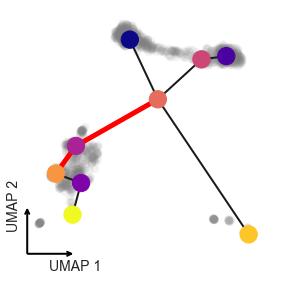

In [25]:
umap_set = set(retina.uns['umap_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(umap_set)))
permutations['retina']['UMAP'] = len(umap_set)
DR_plot(dim_name='UMAP', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='umap', highlight_edges=umap_set, save_to='outputs/plots/ordinal_arrangement/retina_UMAP_MST.png')

3 permuted edges from native space.


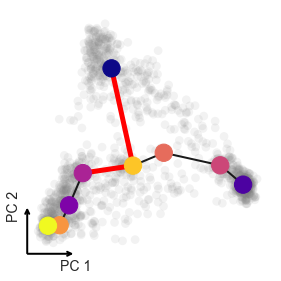

In [26]:
pca2_set = set(retina.uns['pca2_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca2_set)))
permutations['retina']['PCA (2)'] = len(pca2_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='pca2', highlight_edges=pca2_set, save_to='outputs/plots/ordinal_arrangement/retina_PCA2_MST.png')

3 permuted edges from native space.


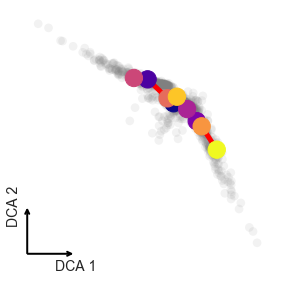

In [27]:
dca_set = set(retina.uns['dca_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(dca_set)))
permutations['retina']['DCA'] = len(dca_set)
DR_plot(dim_name='DCA', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='dca', highlight_edges=dca_set, save_to='outputs/plots/ordinal_arrangement/retina_DCA_MST.png')

4 permuted edges from native space.


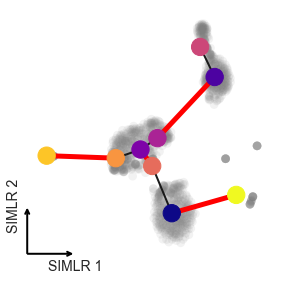

In [28]:
simlr_set = set(retina.uns['simlr_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(simlr_set)))
permutations['retina']['SIMLR'] = len(simlr_set)
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='simlr', highlight_edges=simlr_set, save_to='outputs/plots/ordinal_arrangement/retina_SIMLR_MST.png')

2 permuted edges from native space.


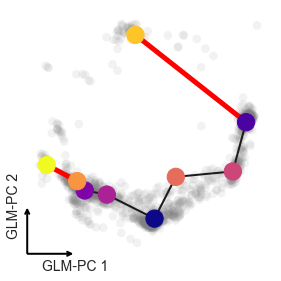

In [29]:
glmpca_set = set(retina.uns['glmpca_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(glmpca_set)))
permutations['retina']['GLM-PCA'] = len(glmpca_set)
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='glmpca', highlight_edges=glmpca_set, save_to='outputs/plots/ordinal_arrangement/retina_GLMPCA_MST.png')

3 permuted edges from native space.


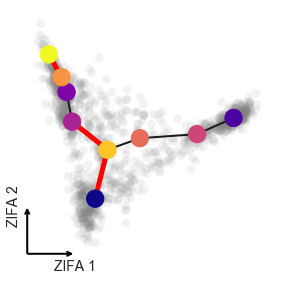

In [30]:
zifa_set = set(retina.uns['zifa_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zifa_set)))
permutations['retina']['ZIFA'] = len(zifa_set)
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='zifa', highlight_edges=zifa_set, save_to='outputs/plots/ordinal_arrangement/retina_ZIFA_MST.png')

3 permuted edges from native space.


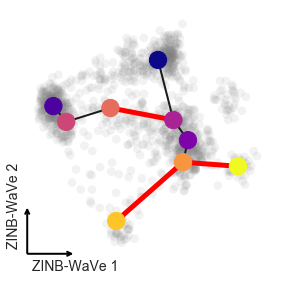

In [31]:
zinbwave_set = set(retina.uns['zinbwave_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zinbwave_set)))
permutations['retina']['ZINB-WaVe'] = len(zinbwave_set)
DR_plot(dim_name='ZINB-WaVe', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='zinbwave', highlight_edges=zinbwave_set, save_to='outputs/plots/ordinal_arrangement/retina_ZINBWAVE_MST.png')

1 permuted edges from native space.


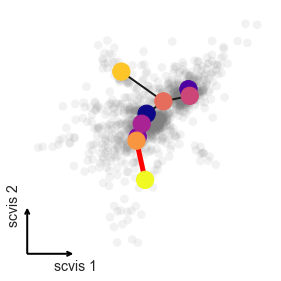

In [32]:
scvis_set = set(retina.uns['scvis_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvis_set)))
permutations['retina']['scvis'] = len(scvis_set)
DR_plot(dim_name='scvis', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='scvis', highlight_edges=scvis_set, save_to='outputs/plots/ordinal_arrangement/retina_scvis_MST.png')

0 permuted edges from native space.


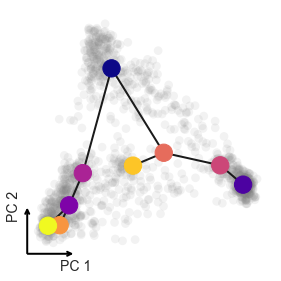

In [33]:
pca10_set = set(retina.uns['pca10_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca10_set)))
permutations['retina']['PCA (10)'] = len(pca10_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='pca10', highlight_edges=pca10_set, save_to='outputs/plots/ordinal_arrangement/retina_PCA10_MST.png')

4 permuted edges from native space.


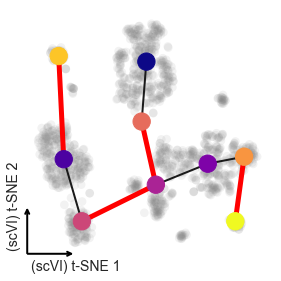

In [34]:
scvi_set = set(retina.uns['scvi_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvi_set)))
permutations['retina']['scVI t-SNE'] = len(scvi_set)
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='scvi', highlight_edges=scvi_set, save_to='outputs/plots/ordinal_arrangement/retina_scVI_MST.png')

---
### Compare MST topology

In [35]:
find_centroids(colon, use_rep='X', obs_col='cluster_fcc')
find_centroids(colon, use_rep='pca2', obs_col='cluster_fcc')
find_centroids(colon, use_rep='tsne', obs_col='cluster_fcc')
find_centroids(colon, use_rep='umap', obs_col='cluster_fcc')
find_centroids(colon, use_rep='dca', obs_col='cluster_fcc')
find_centroids(colon, use_rep='fitsne', obs_col='cluster_fcc')
find_centroids(colon, use_rep='scvi', obs_col='cluster_fcc')
find_centroids(colon, use_rep='zifa', obs_col='cluster_fcc')
find_centroids(colon, use_rep='glmpca', obs_col='cluster_fcc')
find_centroids(colon, use_rep='simlr', obs_col='cluster_fcc')
find_centroids(colon, use_rep='zinbwave', obs_col='cluster_fcc')
find_centroids(colon, use_rep='pca10', obs_col='cluster_fcc')
find_centroids(colon, use_rep='scvis', obs_col='cluster_fcc')

0 permuted edges from native space.


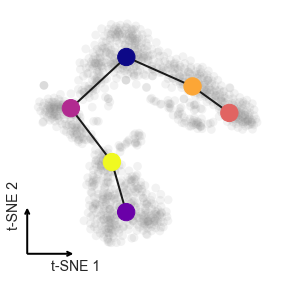

In [36]:
tsne_set = set(colon.uns['tsne_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(tsne_set)))
permutations['colon']['t-SNE'] = len(tsne_set)
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='tsne', highlight_edges=tsne_set, save_to='outputs/plots/ordinal_arrangement/colon_tSNE_MST.png')

0 permuted edges from native space.


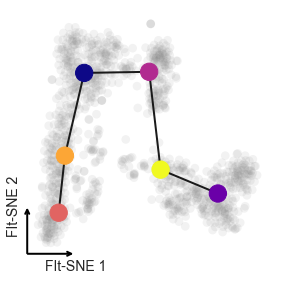

In [37]:
fitsne_set = set(colon.uns['fitsne_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(fitsne_set)))
permutations['colon']['FIt-SNE'] = len(fitsne_set)
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='fitsne', highlight_edges=fitsne_set, save_to='outputs/plots/ordinal_arrangement/colon_FItSNE_MST.png')

0 permuted edges from native space.


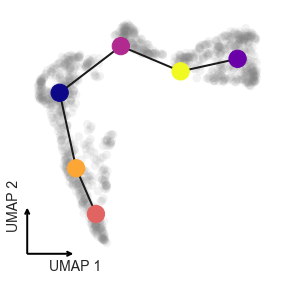

In [38]:
umap_set = set(colon.uns['umap_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(umap_set)))
permutations['colon']['UMAP'] = len(umap_set)
DR_plot(dim_name='UMAP', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='umap', highlight_edges=umap_set, save_to='outputs/plots/ordinal_arrangement/colon_UMAP_MST.png')

0 permuted edges from native space.


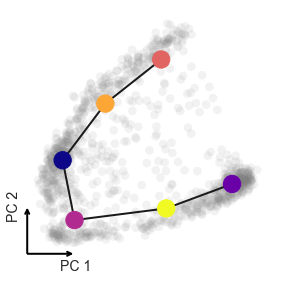

In [39]:
pca2_set = set(colon.uns['pca2_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca2_set)))
permutations['colon']['PCA (2)'] = len(pca2_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='pca2', highlight_edges=pca2_set, save_to='outputs/plots/ordinal_arrangement/colon_PCA2_MST.png')

0 permuted edges from native space.


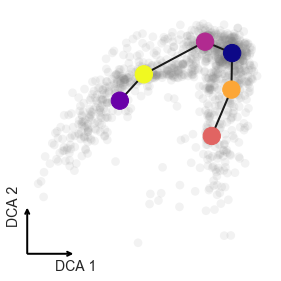

In [40]:
dca_set = set(colon.uns['dca_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(dca_set)))
permutations['colon']['DCA'] = len(dca_set)
DR_plot(dim_name='DCA', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='dca', highlight_edges=dca_set, save_to='outputs/plots/ordinal_arrangement/colon_DCA_MST.png')

0 permuted edges from native space.


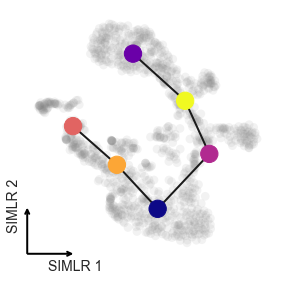

In [41]:
simlr_set = set(colon.uns['simlr_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(simlr_set)))
permutations['colon']['SIMLR'] = len(simlr_set)
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='simlr', highlight_edges=simlr_set, save_to='outputs/plots/ordinal_arrangement/colon_SIMLR_MST.png')

0 permuted edges from native space.


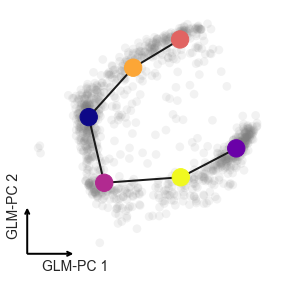

In [42]:
glmpca_set = set(colon.uns['glmpca_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(glmpca_set)))
permutations['colon']['GLM-PCA'] = len(glmpca_set)
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='glmpca', highlight_edges=glmpca_set, save_to='outputs/plots/ordinal_arrangement/colon_GLMPCA_MST.png')

0 permuted edges from native space.


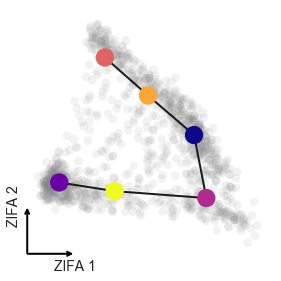

In [43]:
zifa_set = set(colon.uns['zifa_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zifa_set)))
permutations['colon']['ZIFA'] = len(zifa_set)
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='zifa', highlight_edges=zifa_set, save_to='outputs/plots/ordinal_arrangement/colon_ZIFA_MST.png')

0 permuted edges from native space.


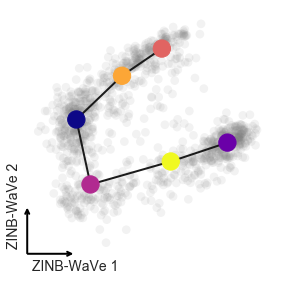

In [44]:
zinbwave_set = set(colon.uns['zinbwave_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zinbwave_set)))
permutations['colon']['ZINB-WaVe'] = len(zinbwave_set)
DR_plot(dim_name='ZINB-WaVe', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='zinbwave', highlight_edges=zinbwave_set, save_to='outputs/plots/ordinal_arrangement/colon_ZINBWAVE_MST.png')

0 permuted edges from native space.


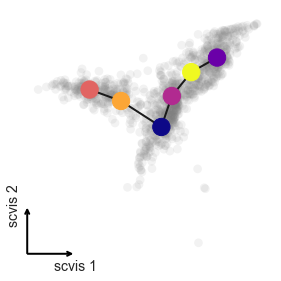

In [45]:
scvis_set = set(colon.uns['scvis_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvis_set)))
permutations['colon']['scvis'] = len(scvis_set)
DR_plot(dim_name='scvis', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='scvis', highlight_edges=scvis_set, save_to='outputs/colon_scvis_MST.png')

0 permuted edges from native space.


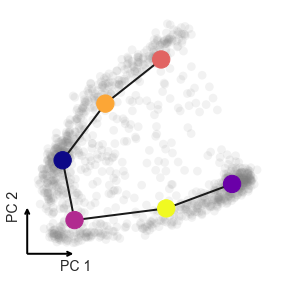

In [46]:
pca10_set = set(colon.uns['pca10_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca10_set)))
permutations['colon']['PCA (10)'] = len(pca10_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='pca10', highlight_edges=pca10_set, save_to='outputs/plots/ordinal_arrangement/colon_PCA10_MST.png')

0 permuted edges from native space.


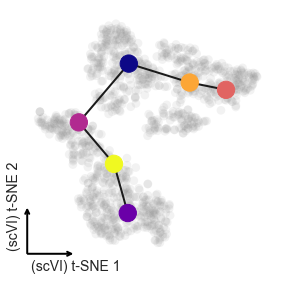

In [47]:
scvi_set = set(colon.uns['scvi_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvi_set)))
permutations['colon']['scVI t-SNE'] = len(scvi_set)
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster_fcc', use_rep='scvi', highlight_edges=scvi_set, save_to='outputs/plots/ordinal_arrangement/colon_scVI_MST.png')

In [48]:
ret = pd.DataFrame(permutations['retina'], index=['Retina'])
col = pd.DataFrame(permutations['colon'], index=['Colon'])
final = pd.concat([ret, col])
final = final.T.sort_values('Retina', ascending=False)

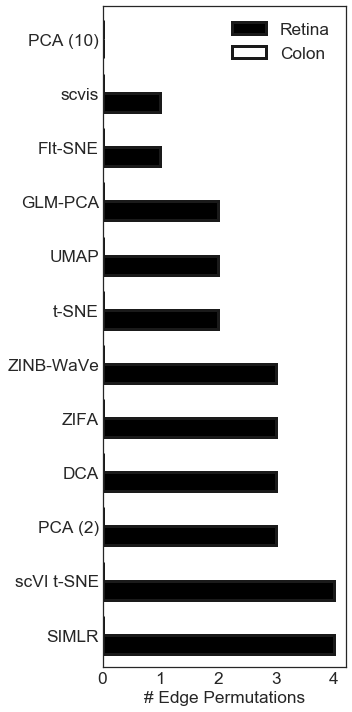

In [52]:
with plt.style.context('seaborn-white'):
    final.plot(kind='barh', width=0.7, figsize=(5,10), color=['black','white'], ec='k', linewidth=3)
    plt.xlabel('# Edge Permutations', fontsize='xx-large')
    plt.yticks(range(0,12), fontsize='xx-large')
    plt.xticks([0,1,2,3,4], fontsize='xx-large')
    plt.legend(fontsize='xx-large')
    plt.tight_layout()
    plt.savefig('outputs/plots/ordinal_arrangement/ordinal_arrangement.png', dpi=700)